<a href="https://colab.research.google.com/github/AndreyKuratov/project_mldm_21/blob/main/MLDM_proj_7_single_NN_train_v5_tp_shift_AnK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import scipy.signal as signal
import os
from tqdm import tqdm
import csv
from pathlib import Path
from PIL import Image
import librosa as lb 
import librosa.display
import IPython.display as ipd
from skimage.transform import resize
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from skimage.transform import resize
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torch.utils.data import DataLoader

import torchvision.models as models
import torch

import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import label_ranking_average_precision_score

# 2. Функции для загрузки теста и трейна и датасеты

In [5]:
def crtclass(mdTp,num_classes=24, pretrained_resnet18=False,pretrained_resnet50=False):
  if mdTp == 'Res18':
    modelF = models.resnet18(pretrained=pretrained_resnet18)
    modelF.fc = nn.Linear(512, num_classes)
  elif mdTp == 'Res34':
    modelF = models.resnet34()
    modelF.fc = nn.Linear(512, num_classes)
  elif mdTp == 'Res50':
    modelF = models.resnet50(pretrained=pretrained_resnet50)
    modelF.fc = nn.Linear(2048, num_classes)
  elif mdTp == 'Alex':
    modelF = models.alexnet()
    modelF.classifier[6] = nn.Linear(4096,num_classes)
  elif mdTp == 'VGG':
    modelF = models.vgg16()
    modelF.classifier[6] = nn.Linear(4096,num_classes)
  elif mdTp == 'Squeez':
    modelF = models.squeezenet1_0()
    modelF.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
  elif mdTp == 'Modile_v3':
    modelF = models.mobilenet_v3_small()
    modelF.classifier[0] = nn.Linear(in_features=576, out_features=4096, bias=True)
    modelF.classifier[3] = nn.Linear(4096,num_classes,bias=True)
  else:
    assert False, 'no model'
  return modelF

def train_step(model,idata,ilabels,criterion,optimizer,DEVICE):
    model.zero_grad()
    idata = idata.type(torch.FloatTensor).to(DEVICE)
    ilabels = ilabels.type(torch.FloatTensor).to(DEVICE)
    train_output = model(idata)
    #optimizer.zero_grad()
    loss = criterion(train_output, ilabels)
    loss.backward()
    optimizer.step()
    return loss.item()

def test_acc(test_loader,model,DEVICE):
    def sigmoid(x):
      return 1 / (1 + np.exp(-x))

    model.eval()
    acc_array=[]
    labels_output = []
    labels_true = []
    with torch.no_grad():
      for i_test_data, i_test_labels in test_loader:
            i_test_data = i_test_data.type(torch.FloatTensor).to(DEVICE)
            i_test_labels = i_test_labels.detach().numpy()
            test_output = model(i_test_data)
            test_output = test_output.cpu().detach().numpy()

            labels_true+=list(i_test_labels)
            labels_output+=list(test_output)
    labels_true = np.array(labels_true)
    labels_output = sigmoid(np.array(labels_output))
    try:
      score = label_ranking_average_precision_score(labels_true, labels_output)
    except:
      score = 0.0
    return score

class simpleDataset(Dataset):
    def __init__(self, numpy_dataset,numpy_labels,transform=None, target_transform=None):
        self.dataset = numpy_dataset
        self.labels = numpy_labels
        self.length = len(numpy_labels)
        self.target_transform = target_transform
        self.transform = transform

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if self.transform != None:
          data = self.transform(self.dataset[idx])
        else:
          data = self.dataset[idx]
        if self.target_transform != None:
          target = self.target_transform(self.labels[idx])
        else:
          target = self.labels[idx]
        return data, target

2б. Аугментации из [RFCX torchvision models augmentation](https://www.kaggle.com/duythanhng/rfcx-torchvision-models-augmentation)

In [6]:
from skimage.transform import resize
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import exposure
import cv2
import numpy as np
import random

class  addNoisy(nn.Module):
    def __call__(self, sample):
      sample = random_noise(sample)
      return sample

class  contrast_stretching(nn.Module):
    def __call__(self, sample):
      sample = np.swapaxes(sample,0,2)
      p2, p98 = np.percentile(sample, (2, 98))
      sample = exposure.rescale_intensity(sample, in_range=(p2, p98))
      sample = np.swapaxes(sample,0,2)
      return sample

class  log_correction(nn.Module):
    def __call__(self, sample):
      sample = exposure.adjust_log(sample)
      return sample

class  randomGaussian(nn.Module):
    def __call__(self, sample):
      sample = gaussian(sample, sigma=random.randint(0, 3))
      return sample


# 3. Обучение

гиперпараметры обучени

In [7]:
BATCH_SIZE = 64
LR = 1e-1
MOMENTUM = 0.9
EPOCH_NUM = 250
STEPS = [10,25,40,80,120,160,200,210,220,230,240]

GAMMA = 0.3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
update_best_models_Flag = True
print(DEVICE)

cuda


### Выделение данных для тренировки

загрузка файлов

In [8]:
PATH_TO_DIR = '/content/drive/MyDrive/mldm21_project/'
PATH_TO_SAVE = '/content/drive/MyDrive/mldm21_project/'
PATH_TO_HELGA = '/content/drive/MyDrive/MLDM_proj/prepared_arrays/'

file_mix = '10k_tp_mixed.npz'
file_shift = '10k_shift.npz'
file_tp = '10k_TP_shift.npz'
file_fp = '10k_FP_shift.npz'

file_tp_audio_aug_1 = 'pure_train_tp_ShiftGauss.npz'
file_tp_audio_aug_2 = 'pure_train_tp_bigGauss.npz'


file_tp_audio_aug_3 = 'pure_train_tp_SbG_0.npz'
file_tp_audio_aug_4 = 'pure_train_tp_SbG_1.npz'
file_tp_audio_aug_5 = 'pure_train_tp_SbG_2.npz'
file_tp_audio_aug_6 = 'pure_train_tp_SbG_3.npz'

file_tp_audio_aug_7 = 'pure_train_tp_SGP.npz'

data_tr = np.load(PATH_TO_SAVE+'pure_train.npz')
data_ts = np.load(PATH_TO_SAVE+'pure_test.npz')
data_tp_tr = np.load(PATH_TO_SAVE+'pure_tp_train.npz')
data_fp_ts = np.load(PATH_TO_SAVE+'pure_fp_test.npz')
data_mts = np.load(PATH_TO_SAVE+'MAJOR_test.npz')

data_10k_shift = np.load(PATH_TO_HELGA+file_shift)
data_10k_mix = np.load(PATH_TO_HELGA+file_mix)

data_tp_aug1 =  np.load(PATH_TO_SAVE+file_tp_audio_aug_1)
data_tp_aug2 =  np.load(PATH_TO_SAVE+file_tp_audio_aug_2)

data_tp_aug3 =  np.load(PATH_TO_SAVE+file_tp_audio_aug_3)
data_tp_aug4 =  np.load(PATH_TO_SAVE+file_tp_audio_aug_4)
data_tp_aug5 =  np.load(PATH_TO_SAVE+file_tp_audio_aug_5)
data_tp_aug6 =  np.load(PATH_TO_SAVE+file_tp_audio_aug_6)

data_tp_aug7 =  np.load(PATH_TO_SAVE+file_tp_audio_aug_7)


data_10k_tp_shift = np.load(PATH_TO_HELGA+file_tp)
data_10k_fp_shift = np.load(PATH_TO_HELGA+file_fp)

test_data = data_ts['data']
test_labels = data_ts['labels']
majot_test_data = data_mts['data']

dataset_type = 'unknown'

#### Создание разных датасетов

Все намешено

In [11]:
train_data = np.concatenate((data_10k_tp_shift['data'][:1000],data_10k_mix['data'][1000:2000],data_tp_aug2['data'],data_tp_aug4['data'],data_tp_aug6['data'],data_tp_aug7['data']),axis=0)
train_labels = np.concatenate((data_10k_tp_shift['labels'][:1000],data_10k_mix['labels'][1000:2000],data_tp_aug2['labels'],data_tp_aug4['labels'],data_tp_aug6['labels'],data_tp_aug7['labels']),axis=0)

dataset_type = 'tp_shift_mix+tp_Aug_bG_ShBg_pitch'

In [64]:
train_data = np.concatenate((data_10k_mix['data'][1000:2000],data_tp_aug4['data'],data_tp_aug5['data'],data_tp_aug6['data'],data_tp_aug7['data']),axis=0)
train_labels = np.concatenate((data_10k_mix['labels'][1000:2000],data_tp_aug4['labels'],data_tp_aug5['labels'],data_tp_aug6['labels'],data_tp_aug7['labels']),axis=0)

dataset_type = 'tp_mix_+tp_Aug_ShBg_pitch'

Загрузка данных tp+fp 

In [ ]:
train_data = data_tr['data']
train_labels = data_tr['labels']


dataset_type = 'tp+fp'

Загрузка данных tp + fp + shift

In [ ]:
IND1 = 5000
IND2 = 8000
train_data = np.concatenate((data_tr['data'],data_10k_shift['data'][IND1:IND2]),axis=0)
train_labels = np.concatenate((data_tr['labels'],data_10k_shift['labels'][IND1:IND2]),axis=0)

dataset_type = 'tp+fp+shift'

Загрузка данных tp + shift

In [ ]:
IND1 = 5000
IND2 = 9000
train_data = np.concatenate((data_tp_tr['data'],data_10k_shift['data'][IND1:IND2]),axis=0)
train_labels = np.concatenate((data_tp_tr['labels'],data_10k_shift['labels'][IND1:IND2]),axis=0)

dataset_type = 'tp+shift'

tp_shift

In [86]:
IND1 = 0
IND2 = 5000
train_data = data_10k_tp_shift['data'][IND1:IND2]
train_labels = data_10k_tp_shift['labels'][IND1:IND2]

dataset_type = 'tp_shift'

fp_shift

In [ ]:
IND1 = 0
IND2 = 6000
train_data = np.concatenate((data_tr['data'],data_10k_fp_shift['data'][IND1:IND2]),axis=0)
train_labels = np.concatenate((data_tr['labels'],data_10k_fp_shift['labels'][IND1:IND2]),axis=0)

dataset_type = 'fp_shift'

Загрузка shift

In [ ]:
IND1 = 5000
IND2 = 10000
train_data = data_10k_shift['data'][IND1:IND2]
train_labels = data_10k_shift['labels'][IND1:IND2]

dataset_type = 'shift'

Загрузка данных tp + fp + mix

In [ ]:
IND = 4000
train_data = np.concatenate((data_tr['data'],data_10k_mix['data'][:IND]),axis=0)
train_labels = np.concatenate((data_tr['labels'],data_10k_mix['labels'][:IND]),axis=0)


dataset_type = 'tp+fp+mix'

Загрузка mix

In [97]:
IND = 4000
train_data = data_10k_mix['data'][:IND]
train_labels = data_10k_mix['labels'][:IND]

dataset_type = 'mix'

Загрузка АудиоАугментаций

частично

In [ ]:

train_data = np.concatenate((data_tp_aug1['data'],data_tp_aug2['data']),axis=0)
train_labels = np.concatenate((data_tp_aug1['labels'],data_tp_aug2['labels']),axis=0)

dataset_type = 'tp_Aug-shiftG+bigG'

In [ ]:
train_data = np.concatenate((data_tp_aug5['data'],data_tp_aug7['data']),axis=0)
train_labels = np.concatenate((data_tp_aug5['labels'],data_tp_aug7['labels']),axis=0)

dataset_type = 'tp_audDiff'

полная

In [ ]:
train_data = np.concatenate((data_tp_aug1['data'],data_tp_aug2['data'],data_tp_aug3['data'],data_tp_aug4['data'],data_tp_aug5['data'],data_tp_aug6['data']),axis=0)
train_labels = np.concatenate((data_tp_aug1['labels'],data_tp_aug2['labels'],data_tp_aug3['labels'],data_tp_aug4['labels'],data_tp_aug5['labels'],data_tp_aug6['labels']),axis=0)

dataset_type = 'tp_Aug_audTotal'

полная+tp

In [ ]:
train_data = np.concatenate((data_tp_tr['data'],data_tp_aug1['data'],data_tp_aug2['data'],data_tp_aug3['data'],data_tp_aug4['data'],data_tp_aug5['data'],data_tp_aug6['data']),axis=0)
train_labels = np.concatenate((data_tp_tr['labels'],data_tp_aug1['labels'],data_tp_aug2['labels'],data_tp_aug3['labels'],data_tp_aug4['labels'],data_tp_aug5['labels'],data_tp_aug6['labels']),axis=0)

dataset_type = 'tp+tp_Aug_audTotal'

полная + fp_2K

In [ ]:
train_data = np.concatenate((data_fp_ts['data'][:2000],data_tp_aug1['data'],data_tp_aug2['data'],data_tp_aug3['data'],data_tp_aug4['data'],data_tp_aug5['data'],data_tp_aug6['data']),axis=0)
train_labels = np.concatenate((data_fp_ts['labels'][:2000],data_tp_aug1['labels'],data_tp_aug2['labels'],data_tp_aug3['labels'],data_tp_aug4['labels'],data_tp_aug5['labels'],data_tp_aug6['labels']),axis=0)

dataset_type = 'fp_2k+tp_Aug_audTotal'

частичная аудио, спектральняа и tp

In [ ]:
IND1 = 0
IND2 = 3000
train_data = np.concatenate((data_10k_fp_shift['data'][IND1:IND2],data_tp_aug1['data'],data_tp_aug2['data'],data_tp_aug3['data'],data_tp_aug4['data']),axis=0)
train_labels = np.concatenate((data_10k_fp_shift['labels'][IND1:IND2],data_tp_aug1['labels'],data_tp_aug2['labels'],data_tp_aug3['labels'],data_tp_aug4['labels']),axis=0)

dataset_type = 'tp_shift_audAug'

#### Создание предтрансформаций

In [ ]:
img_transform = torch.nn.Sequential(
                                    addNoisy(),
                                    contrast_stretching(),
                                    log_correction(),
                                    randomGaussian())
transform_type = '_aNcSlCrG'

In [ ]:
img_transform = torch.nn.Sequential(
                                    contrast_stretching(),
                                    log_correction()
                                    )
transform_type = '_cSlC'

In [19]:
img_transform = torch.nn.Sequential(
                                    addNoisy(),
                                    randomGaussian())
transform_type = '_aNrG'

In [ ]:
img_transform = torch.nn.Sequential(
                                     log_correction())
transform_type = '_lC'

In [26]:
img_transform = torch.nn.Sequential(
                                    randomGaussian())
transform_type = '_rG'

#### Datasets

с

In [27]:
train_dataset = simpleDataset(train_data,train_labels,transform=img_transform)
test_dataset = simpleDataset(test_data,test_labels)
dataset_type_final = dataset_type + transform_type

без

In [98]:
train_dataset = simpleDataset(train_data,train_labels)
test_dataset = simpleDataset(test_data,test_labels)

dataset_type_final = dataset_type

#### Dataloaders

In [99]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Создание сеток

In [45]:
import torch.optim as optim

model_18 = crtclass('Res18',pretrained_resnet18=True).to(DEVICE)
best_model_18 = crtclass('Res18',pretrained_resnet18=True)
criterion_18 = nn.BCEWithLogitsLoss()
optimizer_18 = optim.SGD(model_18.parameters(), lr=LR, momentum=MOMENTUM)
scheduler_18 = optim.lr_scheduler.MultiStepLR(optimizer_18, milestones=STEPS, gamma=GAMMA)

# model_50 = crtclass('Res50',pretrained_resnet50=True).to(DEVICE)
# best_model_50 = crtclass('Res50')
# criterion_50 = nn.BCEWithLogitsLoss()
# optimizer_50 = optim.SGD(model_50.parameters(), lr=LR, momentum=MOMENTUM)

# scheduler_50 = optim.lr_scheduler.MultiStepLR(optimizer_50, milestones=STEPS, gamma=GAMMA)


In [46]:
imodel = model_18
icriterion = criterion_18
ioptimizer = optimizer_18
ibest_model = best_model_18
inamne = 'Res18pt'
ischeduler = scheduler_18
max_score = 0

Загрузка отдельной модели

In [ ]:
imodel = model_50
icriterion = criterion_50
ioptimizer = optimizer_50
ibest_model = best_model_50
inamne = 'Res50pt'
ischeduler = scheduler_50
max_score = 0

In [100]:
PATH_TO_MODEL = '/content/drive/MyDrive/mldm21_project/model_Res50pt_epoch_100_level_tpfpshiht4k_pretraind'
PATH_TO_MODEL = '/content/drive/MyDrive/mldm21_project/model_Res18_epoch_100_level_tpfpshiht4k_pretraind'
PATH_TO_MODEL = '/content/drive/MyDrive/mldm21_project/model_Res18_audSt'

model = crtclass('Res18')
model.load_state_dict(torch.load(PATH_TO_MODEL))
model.eval();
model.to(DEVICE);

In [101]:
import copy

EPOCH_NUM = 210
LR = 1e-4
MOMENTUM = 0.9
STEPS = [20,40,100,120,150]
GAMMA = 0.3
WD = 0.1
inamne = 'Res18_audSt_057'

imodel = model
max_score = 0
ibest_model = copy.deepcopy(imodel)

icriterion = nn.BCEWithLogitsLoss()
#ioptimizer = optim.SGD(imodel.parameters(), lr=LR, momentum=MOMENTUM,weight_decay=WD)
ioptimizer = optim.Adam(imodel.parameters(), lr=LR)

#ischeduler = optim.lr_scheduler.ReduceLROnPlateau(ioptimizer, 'min', factor=0.1, patience=3)
ischeduler = optim.lr_scheduler.MultiStepLR(ioptimizer, milestones=STEPS, gamma=GAMMA)

### Обучение

In [102]:
max_score = 0

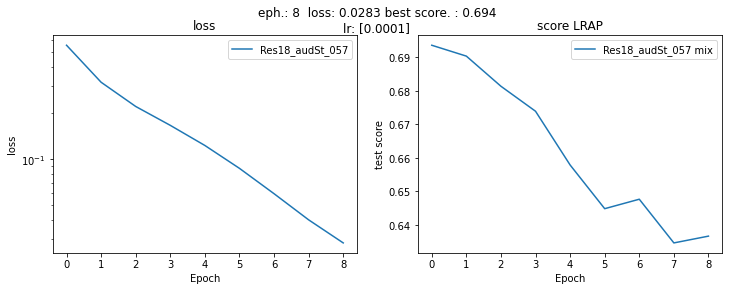

train loader:   0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

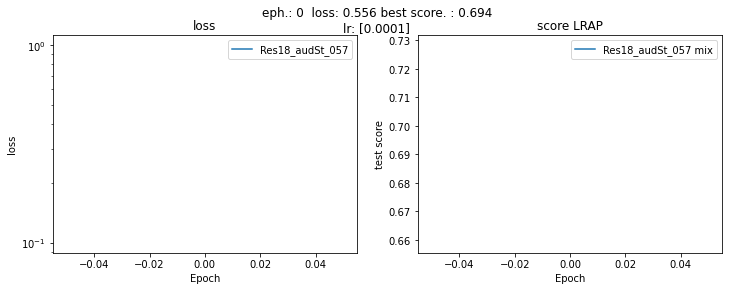

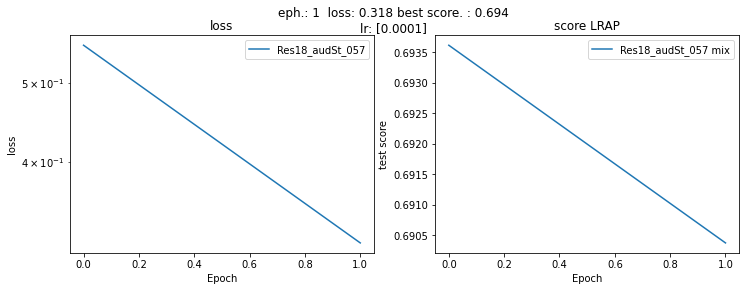

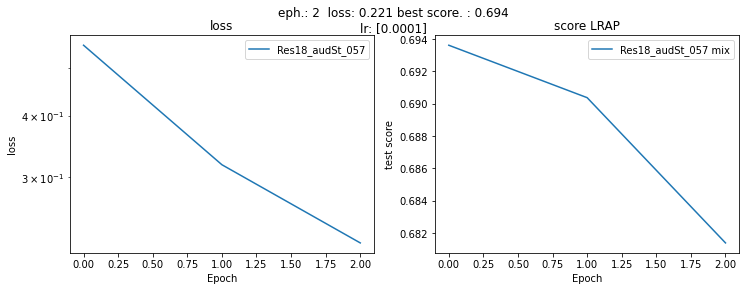

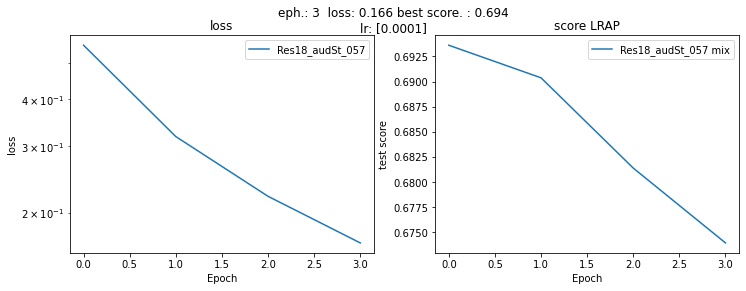

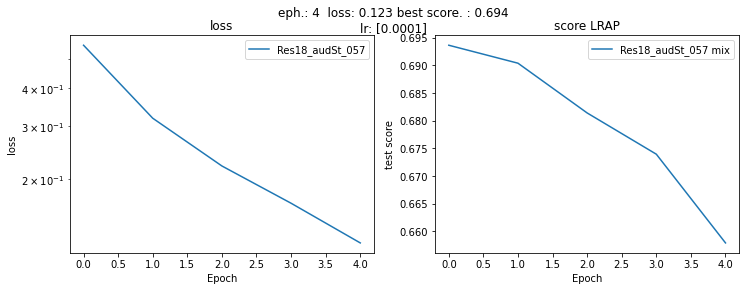

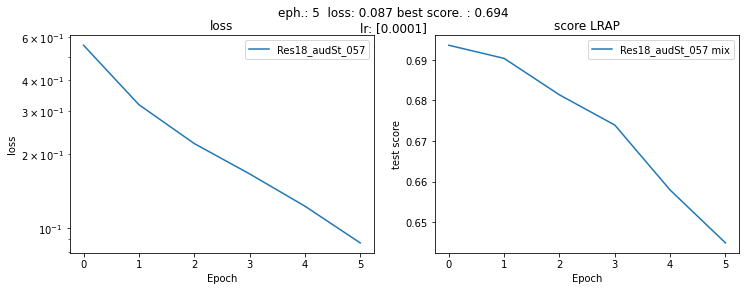

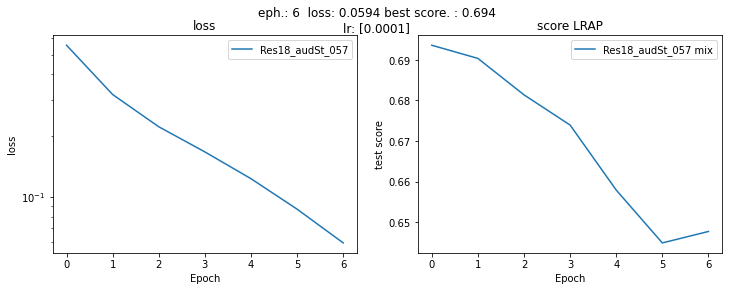

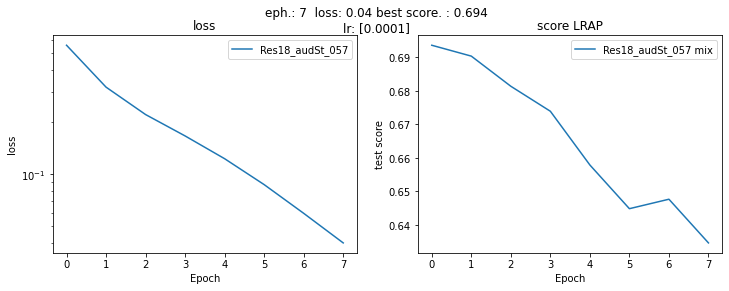

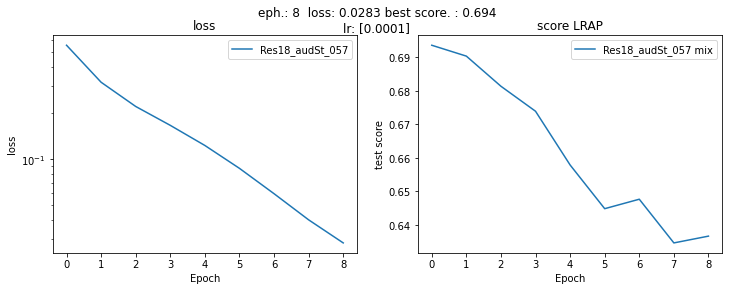

In [103]:
import copy 
from IPython import display
from tqdm.notebook import trange, tqdm

loss_arr = []
test_score_array = []


for iepoch in tqdm(range(EPOCH_NUM),desc='epoch step'):
  inter_loss_arr = []

  imodel.train()
  epoch_loss_arr = []
  epoch_test_acc = []

  for idata, ilabels in tqdm(train_loader,desc='train loader'):
    cur_loss = train_step(imodel,idata,ilabels,icriterion,ioptimizer,DEVICE)
    epoch_loss_arr.append(cur_loss)
  loss_arr.append(np.mean(epoch_loss_arr))
  

  score_cur = test_acc(test_loader,imodel,DEVICE)

  test_score_array.append(score_cur)
  if (score_cur > max_score) and (update_best_models_Flag):
    max_score=score_cur
    sd = imodel.state_dict()
    ibest_model.load_state_dict(sd)

  strOUT_1 = 'eph.: {:} '.format(iepoch)
  strOUT_2 = 'loss: {:.3}'.format(loss_arr[-1])
  strOUT_4 =  'best score. : {:.3}'.format(max_score)
  strOUT_5 = 'lr: {:}'.format(ischeduler.get_last_lr())

  # plot figures in epoch
  loss_arr_np = np.array(loss_arr)
  test_score_array_np = np.array(test_score_array)

  plt.figure(figsize=(12,4))
  plt.subplot(1,2,1)
  plt.suptitle(strOUT_1+' '+strOUT_2+' '+strOUT_4 + '\n'+ strOUT_5)
  plt.title('loss')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.yscale('log')
  plt.plot(loss_arr_np,label=inamne)
  plt.legend()
  plt.subplot(1,2,2)
  plt.title('score LRAP')
  plt.xlabel('Epoch')
  plt.ylabel('test score')
  plt.plot(test_score_array_np,label=inamne+' '+dataset_type_final)
  plt.legend()

  display.clear_output(wait=True)
  display.display(plt.gcf())
  #ischeduler.step(cur_loss)
  ischeduler.step()

### Сохранение модели

In [ ]:
# types of generation
# -1 - train only TP data with single label
# 0  - train only TP data
# 1  - train TP&FP data
# 2  - inside record augmented data
# 3  - outside record augmented data

generation = 'tpfpshiht4k_pretraind'

for idx,inamne in enumerate(ModelNames):
  PATH = '/content/drive/MyDrive/mldm21_project/'
  torch.save(best_models_arr[idx].state_dict(), PATH+'model_{}_epoch_{:}_level_{}'.format(inamne,EPOCH_NUM,generation))


In [105]:
PATH = '/content/drive/MyDrive/mldm21_project/'
modelNname = 'model_Res18_temp_2'
#torch.save(ibest_model.state_dict(), PATH+modelNname)
torch.save(imodel.state_dict(), PATH+modelNname)

In [110]:
PATH_TO_MODEL = '/content/drive/MyDrive/mldm21_project/model_Res18_temp_2'


model = crtclass('Res18')
model.load_state_dict(torch.load(PATH_TO_MODEL))
model.eval();
model.to(DEVICE);

In [111]:
score_cur = test_acc(test_loader,model,DEVICE)
print('SCORE: {:.4}'.format(score_cur))

SCORE: 0.6394


### Создание файлов с результатами

In [112]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

majot_test_data = data_mts['data']
majot_test_labels = data_mts['files']
i_num = len(majot_test_labels)
columns = ['recording_id'] + [ 's'+str(inm)  for inm in range(24)]

results = []


for indx in tqdm(range(i_num)):
  idata = torch.Tensor([majot_test_data[indx]]).to(DEVICE)
  output = model(idata).cpu().detach().numpy()
  out_sigm = sigmoid(output)
  results.append(out_sigm)



  0%|          | 0/1992 [00:00<?, ?it/s]

In [113]:
File_csv = 'model_Res18_temp_2'
PATH_TO_SAVE_RESULTS = '/content/drive/MyDrive/mldm21_project/{}.csv'.format(File_csv)


res_np = np.squeeze(np.array(results))
dict_to_save = {columns[i+1] : res_np[:,i] for i in range(24)} 
dict_to_save['recording_id'] = majot_test_labels
DF_result = pd.DataFrame(dict_to_save,columns=columns)
DF_result.to_csv(PATH_TO_SAVE_RESULTS,index=False)



> * **Submitted**: model_Res18_epoch_30_level_1_result.csv
* **score** : 0.52114




In [ ]:
import gc
gc.collect()

0

In [ ]:
torch.cuda.empty_cache()

In [ ]:
ischeduler.get_last_lr()

0.001